# Juliet Example of KELT 11 for Detrending CHEOPS data

## Import der Packages

In [7]:
import juliet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.mast import Catalogs
from tess_stars2px import tess_stars2px_function_entry
import os
from astropy.io import fits
import corner
import pycheops
import astropy.constants as astrocon
from scipy import interpolate
from scipy.interpolate import interp1d
from uncertainties import ufloat

Hier gibst du denselben Ordner ein, in dem du auch das Notebook hast.

In [ ]:
path=''

In [4]:
def _make_interp(t,x,scale=None):
    if scale is None:
        z = x
    elif scale == 'max':
        z = (x-min(x))/np.ptp(x)
    elif scale == 'range':
        z = (x-np.median(x))/np.ptp(x)
    else:
        raise ValueError('scale must be None, max or range')
    return interp1d(t,z,bounds_error=False, fill_value=(z[0],z[-1]))

Wir lesen die Daten ein, indem wir hier den File Key, den wir auch im pycheops Notebook genutzt haben und die Aperture, die wir als beste ausgewählt haben.

In [5]:
file_key = 'CH_PR300024_TG000101_V0200'
aperture = 'DEFAULT'
sig_clip = 3

## Daten einlesen

In [6]:
dataset = pycheops.Dataset(file_key,verbose=True)
time,flux,flux_err = dataset.get_lightcurve(aperture=aperture,decontaminate=True,verbose=False)

time, flux, flux_err = dataset.clip_outliers(clip=sig_clip, verbose=False)
time = time+dataset.lc['bjd_ref']
print(time)

xoff_mod = dataset.lc['xoff']
yoff_mod = dataset.lc['yoff']
phi_mod = dataset.lc['roll_angle']*np.pi/180
bg_mod = dataset.lc['bg']
contam_mod = dataset.lc['contam']
smear_mod = dataset.lc['smear']
deltaT_mod = dataset.lc['deltaT']/1e6

Found archive tgzfile /Users/yoshi/pycheops/data/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
[2458918.1248805 2458918.1252283 2458918.1255761 ... 2458918.7025746
 2458918.7029224 2458918.7032702]


Hier werden die Detrending Vektoren definiert. In dem kommentierten Bereich, gibst du die Vektoren ein, die Du im pycheops Notebook gefunden hast.

In [ ]:
dt = time - np.median(time)
dt2 = dt**2
dt3 = dt**3

dx = _make_interp(time, xoff_mod, scale='range')(time)
dx2 = dx**2
dy = _make_interp(time, yoff_mod, scale='range')(time)
dy2 = dy**2

bg = _make_interp(time, bg_mod, scale='max')(time)
contam = _make_interp(time, contam_mod, scale='max')(time)
smear = _make_interp(time, smear_mod, scale='max')(time)
deltaT = _make_interp(time, deltaT_mod)(time)

sinphi = _make_interp(time, np.sin(phi_mod))(time)
cosphi = _make_interp(time, np.cos(phi_mod))(time)
sin2phi = 2*sinphi*cosphi
cos2phi = 2*cosphi**2 - 1
sin3phi = 3*sinphi - 4*sinphi**3
cos3phi = 4*cosphi**3 - 3*cosphi

############################################################################################################
# Enter the Detrending Vectors you noted down
instr_BVs = np.array([contam, bg])
############################################################################################################

lrs = [[]]*len(time)
for index, i in enumerate(time):
    lrs[index] = instr_BVs.T[index]
lrs = np.array(lrs)

instrument = 'CHEOPS'
times, fluxes, fluxes_error = {},{},{}
times[instrument], fluxes[instrument], fluxes_error[instrument] = time, flux, flux_err
linear_regressors = {}
linear_regressors[instrument] = lrs

Hier geben wir die Eigenschaften des Sterns und Transits ein. Rstar und Mstar kannst du auf Exoplanet Archive nachschauen. P, t0 und depth kannst du auf deinen TESS juliet Ergebnissen nehmen.

In [12]:
tic=55092869 #Enter the TIC ID here
catalog_data = Catalogs.query_object(f"TIC {tic}", catalog="TIC")
row = catalog_data[0]
Mstar=ufloat(2.282000,0.4)*astrocon.M_sun.value
Rstar=ufloat(1.6174400,0.04)*astrocon.R_sun.value
rhostar = Mstar/((4*np.pi/3)*Rstar**3)
print(rhostar)
P=4.736205811608462 #in days
t0=2457483.4309231522 #in BJD
depth=0.045551085388766836
rhostar = Mstar/((4*np.pi/3)*Rstar**3)

(7.6+/-1.4)e+02


Diese Werte werden nun in die Priors gegeben.

In [13]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','p_p1','b_p1','ecc_p1','omega_p1',
          'rho',

          'q1_'+instrument,'mdilution_'+instrument,'mflux_'+instrument,'sigma_w_'+instrument,
         ]

# Distributions:
dists = ['fixed','normal','fixed','fixed','fixed','fixed',
         'normal',

         'uniform','fixed','normal','loguniform'
        ]

# Hyperparameters
hyperps = [P,[t0,0.002], depth,0.,0.,0.,
            [rhostar.n, rhostar.s],

           [0,1],1.0,[0,0.1],[0.1,1000]
          ]

for i in np.arange(0,np.shape(lrs)[1]):
    params.append("theta"+str(i)+"_CHEOPS")
    dists.append("uniform")
    hyperps.append([-1,1])

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

for index, i in enumerate(priors):
    print(i, priors[i])

P_p1 {'distribution': 'fixed', 'hyperparameters': 4.736205811608462}
t0_p1 {'distribution': 'normal', 'hyperparameters': [2457483.4309231522, 0.002]}
p_p1 {'distribution': 'fixed', 'hyperparameters': 0.045551085388766836}
b_p1 {'distribution': 'fixed', 'hyperparameters': 0.0}
ecc_p1 {'distribution': 'fixed', 'hyperparameters': 0.0}
omega_p1 {'distribution': 'fixed', 'hyperparameters': 0.0}
rho {'distribution': 'normal', 'hyperparameters': [760.2954535262977, 144.71425706837812]}
q1_CHEOPS {'distribution': 'uniform', 'hyperparameters': [0, 1]}
mdilution_CHEOPS {'distribution': 'fixed', 'hyperparameters': 1.0}
mflux_CHEOPS {'distribution': 'normal', 'hyperparameters': [0, 0.1]}
sigma_w_CHEOPS {'distribution': 'loguniform', 'hyperparameters': [0.1, 1000]}
theta0_CHEOPS {'distribution': 'uniform', 'hyperparameters': [-1, 1]}
theta1_CHEOPS {'distribution': 'uniform', 'hyperparameters': [-1, 1]}


Und wir lassen den Juliet laufen:

In [14]:
outdir = path+'CHEOPS_KELT11'
dataset = juliet.load(priors = priors, t_lc = times, y_lc = fluxes, yerr_lc = fluxes_error,
                      linear_regressors_lc = linear_regressors,
                      out_folder = outdir,
                      verbose=True)

results = dataset.fit(n_live_points=300, use_dynesty=True)#, dynesty_nthreads = 3)
print("lnZ is: ",results.posteriors['lnZ'])

	 Transit fit detected for instrument  CHEOPS
	 >> ecc,omega parametrization detected for lc planet p1


17405it [07:47, 37.26it/s, +300 | bound: 365 | nc: 1 | ncall: 452093 | eff(%):  3.919 | loglstar:   -inf < 10527.926 <    inf | logz: 10471.164 +/-  0.430 | dlogz:  0.001 >  0.309]


lnZ is:  10471.164142353779


Und wir plotten die Ergebnisse:

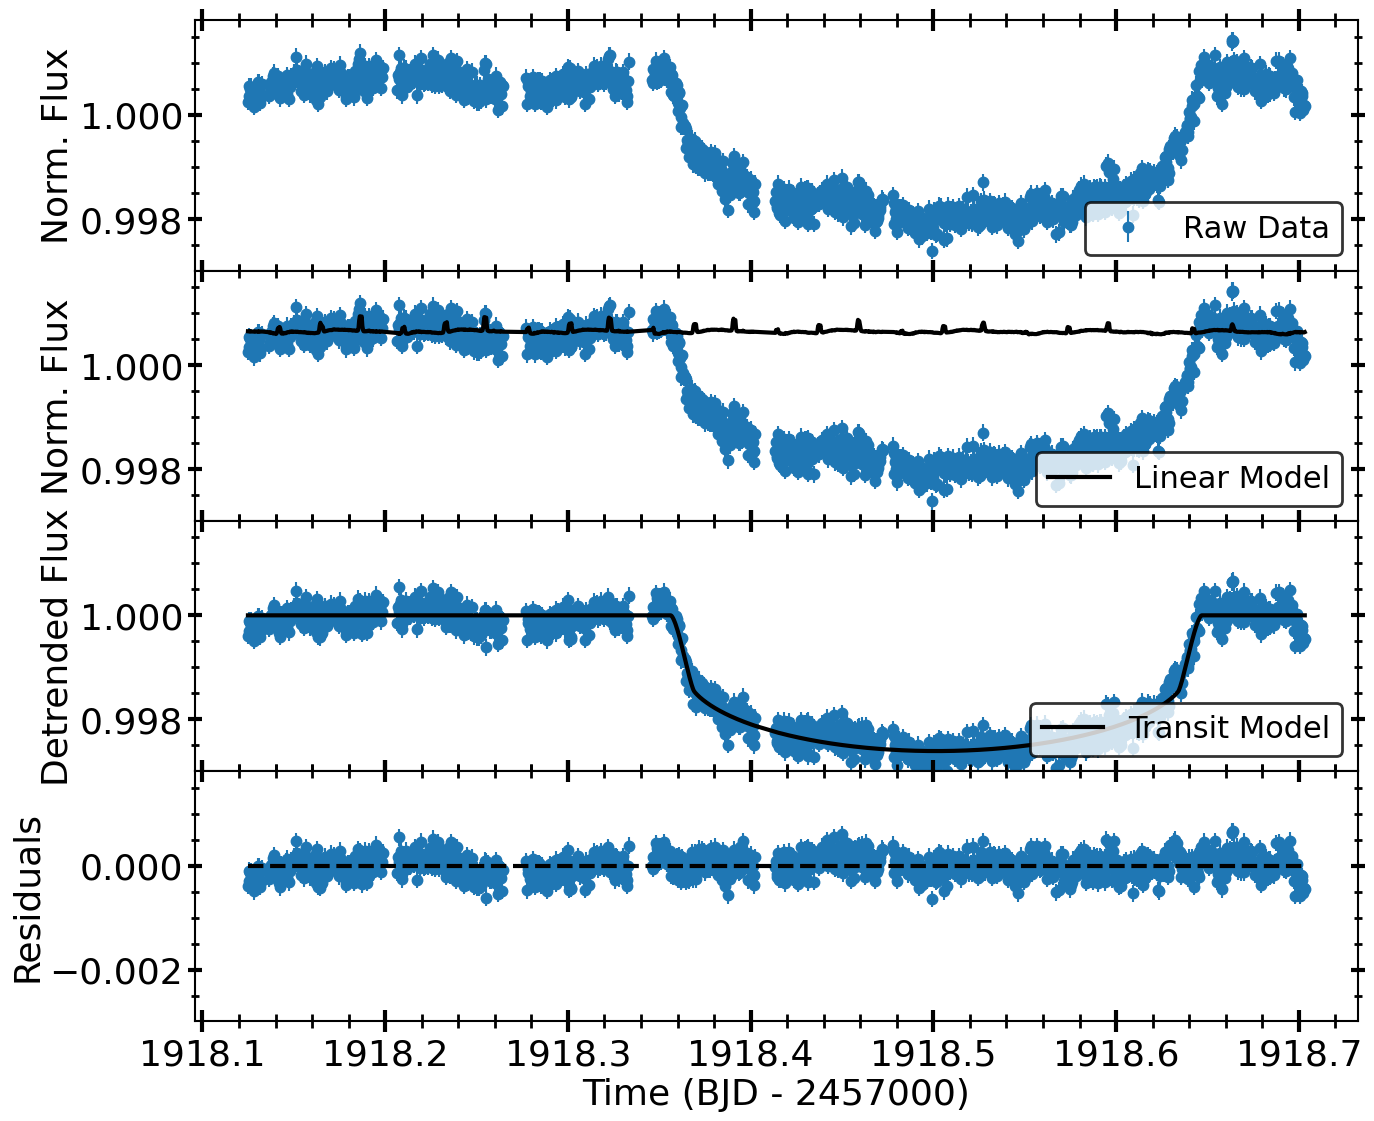

In [15]:
fig, ax1 = plt.subplots(nrows=4,sharex=True,figsize=(15,13))
plt.subplots_adjust(wspace=0, hspace=0)

transit_model, transit_up68, transit_low68, components  = results.lc.evaluate('CHEOPS', return_err=True, \
                                                                                  return_components = True, \
                                                                                  all_samples = False)

ax1[0].errorbar(dataset.times_lc['CHEOPS'] - 2457000,
                dataset.data_lc['CHEOPS'],
                yerr = dataset.errors_lc['CHEOPS'],
                fmt = '.',
                ms=15, label="Raw Data")

ax1[1].errorbar(dataset.times_lc['CHEOPS'] - 2457000,
                dataset.data_lc['CHEOPS'],
                yerr = dataset.errors_lc['CHEOPS'],
                fmt = '.',
                ms=15)

# Out-of-transit flux:
oot_flux = np.median(1./(1. + results.posteriors['posterior_samples']['mflux_CHEOPS']))

# Plot non-transit model::
ax1[1].plot(dataset.times_lc['CHEOPS'] - 2457000,
            oot_flux + components['lm'], color='k', lw = 3, zorder=5, label = "Linear Model")

model_times = np.linspace(dataset.times_lc['CHEOPS'][0],dataset.times_lc['CHEOPS'][-1],len(dataset.times_lc['CHEOPS']))

ax1[2].plot(dataset.times_lc['CHEOPS'] - 2457000, components['transit'],
            color='k', lw = 3, zorder=5, label = "Transit Model")

ax1[2].errorbar(dataset.times_lc['CHEOPS'] - 2457000,
                dataset.data_lc['CHEOPS']/(oot_flux + components['lm']), \
                yerr = dataset.errors_lc['CHEOPS']/(oot_flux),
                fmt = '.',
                ms=15)

ax1[3].errorbar(dataset.times_lc['CHEOPS'] - 2457000,
                (dataset.data_lc['CHEOPS']/(oot_flux + components['lm']))-components['transit'], \
                yerr = dataset.errors_lc['CHEOPS'],
                fmt = '.',
                ms=15)
ax1[3].plot([dataset.times_lc['CHEOPS'][0] - 2457000,dataset.times_lc['CHEOPS'][-1] - 2457000], [0,0], color='k', ls="--", lw = 3, zorder=5)

res = (dataset.data_lc['CHEOPS']/(oot_flux + components['lm']))-components['transit']


ax1[3].set_xlabel('Time (BJD - 2457000)', fontsize=26)

ax1[0].set_ylabel('Norm. Flux', fontsize=26)
ax1[1].set_ylabel('Norm. Flux', fontsize=26)
ax1[2].set_ylabel('Detrended Flux', fontsize=26)
ax1[3].set_ylabel('Residuals', fontsize=26)

ax1[0].tick_params(axis='both', labelsize=26)
ax1[0].tick_params(axis="x", direction="inout", length=16, width=3, which='major', bottom=True, top=True)
ax1[0].tick_params(axis="y", direction="inout", length=10, width=3, which='major', left=True, right=True)
ax1[0].tick_params(axis="x", direction="inout", length=10, width=2, which='minor', bottom=True, top=True)
ax1[0].tick_params(axis="y", direction="inout", length=6, width=2, which='minor', left=True, right=True)
for axis in ['top','bottom','left','right']:
    ax1[0].spines[axis].set_linewidth(1.5)
ax1[1].tick_params(axis='both', labelsize=26)
ax1[1].tick_params(axis="x", direction="inout", length=16, width=3, which='major', bottom=True, top=True)
ax1[1].tick_params(axis="y", direction="inout", length=10, width=3, which='major', left=True, right=True)
ax1[1].tick_params(axis="x", direction="inout", length=10, width=2, which='minor', bottom=True, top=True)
ax1[1].tick_params(axis="y", direction="inout", length=6, width=2, which='minor', left=True, right=True)
for axis in ['top','bottom','left','right']:
    ax1[1].spines[axis].set_linewidth(1.5)
ax1[2].tick_params(axis='both', labelsize=26)
ax1[2].tick_params(axis="x", direction="inout", length=16, width=3, which='major', bottom=True, top=True)
ax1[2].tick_params(axis="y", direction="inout", length=10, width=3, which='major', left=True, right=True)
ax1[2].tick_params(axis="x", direction="inout", length=10, width=2, which='minor', bottom=True, top=True)
ax1[2].tick_params(axis="y", direction="inout", length=6, width=2, which='minor', left=True, right=True)
for axis in ['top','bottom','left','right']:
    ax1[2].spines[axis].set_linewidth(1.5)
ax1[3].tick_params(axis='both', labelsize=26)
ax1[3].tick_params(axis="x", direction="inout", length=16, width=3, which='major', bottom=True, top=True)
ax1[3].tick_params(axis="y", direction="inout", length=10, width=3, which='major', left=True, right=True)
ax1[3].tick_params(axis="x", direction="inout", length=10, width=2, which='minor', bottom=True, top=True)
ax1[3].tick_params(axis="y", direction="inout", length=6, width=2, which='minor', left=True, right=True)
for axis in ['top','bottom','left','right']:
    ax1[3].spines[axis].set_linewidth(1.5)

from matplotlib.ticker import AutoMinorLocator
ax1[0].xaxis.set_minor_locator(AutoMinorLocator())
ax1[0].yaxis.set_minor_locator(AutoMinorLocator())
ax1[1].xaxis.set_minor_locator(AutoMinorLocator())
ax1[1].yaxis.set_minor_locator(AutoMinorLocator());
ax1[2].xaxis.set_minor_locator(AutoMinorLocator())
ax1[2].yaxis.set_minor_locator(AutoMinorLocator());
ax1[3].xaxis.set_minor_locator(AutoMinorLocator())
ax1[3].yaxis.set_minor_locator(AutoMinorLocator());

leg = ax1[0].legend(loc = 4, fontsize=22)
leg.get_frame().set_linewidth(2)
leg.get_frame().set_edgecolor("k")
leg = ax1[1].legend(loc = 4, fontsize=22)
leg.get_frame().set_linewidth(2)
leg.get_frame().set_edgecolor("k")
leg = ax1[2].legend(loc = 4, fontsize=22)
leg.get_frame().set_linewidth(2)
leg.get_frame().set_edgecolor("k")

ax1[3].ticklabel_format(axis='x', useOffset=False)

ax1[2].set_ylim(ax1[0].get_ylim())
ax1[3].set_ylim(ax1[0].get_ylim()[0]-1,ax1[0].get_ylim()[1]-1);

plt.savefig(outdir+"/"+file_key+"_raw+lm+tr+res_W.png", bbox_inches = 'tight', pad_inches = 0)

flux_d = dataset.data_lc['CHEOPS']/(oot_flux + components['lm'])

flux_err_dlm = []
for jindex, j in enumerate(dataset.errors_lc['CHEOPS']):
    BV_coeffs_sum_ind = 0
    for i in np.arange(0,np.shape(lrs)[1]):
        BV_coeffs_sum_ind += (np.std(results.posteriors['posterior_samples']['theta'+str(i)+'_CHEOPS']) * float(lrs[jindex][i]) )**2
    flux_err_dlm.append(np.sqrt( (dataset.errors_lc['CHEOPS'][jindex]/flux_d[jindex])**2 + BV_coeffs_sum_ind))

with open(outdir+"/"+file_key+'_detrendedLC.dat', 'w') as writer:
    writer.write('BJD,flux_d,flux_d_err'+"\n")
    for index, i in enumerate(dataset.times_lc['CHEOPS']):
        writer.write(str(dataset.times_lc['CHEOPS'][index])+","+str(flux_d[index])+","+str(flux_err_dlm[index])+"\n")
plt.show()